In [ ]:
import sys
import os
import numpy as np
import cv2
from matplotlib import pyplot as plt
import keras
from keras import backend as K
from keras.preprocessing import image

import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

tf.enable_eager_execution()
from tensorflow.python.framework import ops

Using TensorFlow backend.


Instructions for updating:
non-resource variables are not supported in the long term


In [ ]:
data_dir = '/content/drive/My Drive/data_Yonathan/'
def load_model_and_weights(name):
  # load json and create model
  json_file = open(data_dir + name + '.json', 'r')
  loaded_model_json = json_file.read()
  json_file.close()
  loaded_model = keras.models.model_from_json(loaded_model_json)
  # load weights into new model
  loaded_model.load_weights(data_dir + name + '.h5')
  return loaded_model

In [ ]:
backbone_output_layer_name = 'conv5_block8_concat'
def build_model(backbone_output_layer_name):
  return load_model_and_weights('tmp')
  # backbone_model = load_model_and_weights('simple_backbone_model')
  # head_model = load_model_and_weights('simple_head_model - exp 3')
  # model_input = backbone_model.input
  # backbone_intermediate_output = backbone_model.get_layer(head_model.layers[0].name).output
  # model_output = head_model(backbone_intermediate_output)
  # model = keras.models.Model(inputs=model_input, outputs=model_output)
  # return model
  
  # backbone_model = load_model_and_weights('simple_backbone_model')
  # head_model = load_model_and_weights('simple_head_model - exp 3')
  # for backbone_layer in backbone_model.layers[-25:]:
  #   backbone_layer_name = backbone_layer.name
  #   try:
  #     head_layer = head_model.get_layer(backbone_layer_name)
  #   except:
  #     print(f'Layer {backbone_layer_name} not found in head model')
  #     raise
  #   try:
  #     head_weights = head_layer.get_weights()
  #   except:
  #     print(f'Layer {backbone_layer_name} has no weights')
  #     raise
  #   try:
  #     backbone_layer.set_weights(head_weights)
  #   except:
  #     print(f'Could not set weights. Head weights shape: {head_weights.shape}, backbone weights shape: {backbone_layer.weights[0].numpy().shape}')
  #     print(head_weights)
  #     print(backbone_layer.weights[0].numpy())
  #     raise
  
  # model_input = backbone_model.input
  # x = backbone_model(model_input)
  # x = head_model.layers[-1](x)
  # model = keras.models.Model(input=model_input, output=x)
  # return model


In [ ]:
H, W = 224, 224 # Input shape, defined by the model (model.input_shape)
# ---------------------------------------------------------------------

def load_image(path, preprocess=True):
  """Load and preprocess image."""
  x = image.load_img(path, target_size=(H, W))
  if preprocess:
      x = image.img_to_array(x)
      x = np.expand_dims(x, axis=0)
      x = preprocess_input(x)
  return x

def preprocess_input(x):
  return x / 255.

def deprocess_image(x):
  """Same normalization as in:
  https://github.com/fchollet/keras/blob/master/examples/conv_filter_visualization.py
  """
  return x * 255.


def normalize(x):
  """Utility function to normalize a tensor by its L2 norm"""
  return (x + 1e-10) / (K.sqrt(K.mean(K.square(x))) + 1e-10)


def build_guided_model(backbone_output_layer_name):
  """Function returning modified model.
  
  Changes gradient function for all ReLu activations
  according to Guided Backpropagation.
  """
  if "GuidedBackProp" not in ops._gradient_registry._registry:
      @ops.RegisterGradient("GuidedBackProp")
      def _GuidedBackProp(op, grad):
          dtype = op.inputs[0].dtype
          return grad * tf.cast(grad > 0., dtype) * \
                  tf.cast(op.inputs[0] > 0., dtype)

  g = tf.get_default_graph()
  with g.gradient_override_map({'Relu': 'GuidedBackProp'}):
      new_model = build_model(backbone_output_layer_name)
  return new_model


def guided_backprop(input_model, images, layer_name):
  """Guided Backpropagation method for visualizing input saliency."""
  input_imgs = input_model.input
  layer_output = input_model.get_layer(layer_name).output
  grads = K.gradients(layer_output, input_imgs)[0]
  backprop_fn = K.function([input_imgs, K.learning_phase()], [grads])
  grads_val = backprop_fn([images, 0])[0]
  return grads_val


def grad_cam(input_model, image, layer_name):
  """GradCAM method for visualizing input saliency."""
  y_c = input_model.output[0, 0]
  conv_output = input_model.get_layer(layer_name).output
  grads = K.gradients(y_c, conv_output)[0]
  # Normalize if necessary
  # grads = normalize(grads)
  gradient_function = K.function([input_model.input], [conv_output, grads])
  output, grads_val = gradient_function([image])
  output, grads_val = output[0, :], grads_val[0, :, :, :]

  weights = np.mean(grads_val, axis=(0, 1))
  cam = np.dot(output, weights)

  # Process CAM
  cam = cv2.resize(cam, (W, H), cv2.INTER_LINEAR)
  cam = np.maximum(cam, 0)
  cam_max = cam.max() 
  if cam_max != 0: 
    cam = cam / cam_max
  return cam
    
def grad_cam_batch(input_model, images, classes, layer_name):
  """GradCAM method for visualizing input saliency.
  Same as grad_cam but processes multiple images in one run."""
  loss = tf.gather_nd(input_model.output, np.dstack([range(images.shape[0]), classes])[0])
  layer_output = input_model.get_layer(layer_name).output
  grads = K.gradients(loss, layer_output)[0]
  gradient_fn = K.function([input_model.input, K.learning_phase()], [layer_output, grads])

  conv_output, grads_val = gradient_fn([images, 0])    
  weights = np.mean(grads_val, axis=(1, 2))
  cams = np.einsum('ijkl,il->ijk', conv_output, weights)
  
  # Process CAMs
  new_cams = np.empty((images.shape[0], W, H))
  for i in range(new_cams.shape[0]):
    cam_i = cams[i] - cams[i].mean()
    cam_i = (cam_i + 1e-10) / (np.linalg.norm(cam_i, 2) + 1e-10)
    new_cams[i] = cv2.resize(cam_i, (H, W), cv2.INTER_LINEAR)
    new_cams[i] = np.maximum(new_cams[i], 0)
    new_cams[i] = new_cams[i] / new_cams[i].max()
    
    return new_cams

def decode_predictions(predictions):
  '''prediction is a probability between 0 and 1, with 1 = without objects'''
  return [[('without objects', p), ('with objects', 1 - p)] for p in predictions]

def compute_saliency(model, guided_model, img_path, layer_name='block5_conv3', visualize=True, save=True):
  """Compute saliency using all three approaches.
  -layer_name: layer to compute gradients;
  """
  preprocessed_input = load_image(img_path)

  predictions = model.predict(preprocessed_input)
  top = decode_predictions(predictions)
  print(f'predictions shape: {predictions.shape}')
  classes = np.argsort(predictions[0])[::-1]
  print('Model prediction:')
  for c, p in zip(classes, top):
    print(f'    {p[0]}    ({c})    with probability {p[1]}')

    
  gradcam = grad_cam(model, preprocessed_input, layer_name)
  gb = guided_backprop(guided_model, preprocessed_input, layer_name)
  guided_gradcam = gb * gradcam[..., np.newaxis]

  if save:
    jetcam = cv2.applyColorMap(np.uint8(255 * gradcam), cv2.COLORMAP_JET)
    jetcam = (np.float32(jetcam) + load_image(img_path, preprocess=False)) / 2
    cv2.imwrite('gradcam.jpg', np.uint8(jetcam))
    cv2.imwrite('guided_backprop.jpg', deprocess_image(gb[0]))
    cv2.imwrite('guided_gradcam.jpg', deprocess_image(guided_gradcam[0]))
    
  if visualize:
    plt.figure(figsize=(15, 10))
    plt.subplot(131)
    plt.title('GradCAM')
    plt.axis('off')
    plt.imshow(load_image(img_path, preprocess=False))
    plt.imshow(gradcam, cmap='jet', alpha=0.5)

    plt.subplot(132)
    plt.title('Guided Backprop')
    plt.axis('off')
    plt.imshow(np.flip(deprocess_image(gb[0]), -1))
    
    plt.subplot(133)
    plt.title('Guided GradCAM')
    plt.axis('off')
    plt.imshow(np.flip(deprocess_image(guided_gradcam[0]), -1))
    plt.show()
    
  return gradcam, gb, guided_gradcam

In [ ]:
model = build_model(backbone_output_layer_name)
guided_model = build_guided_model(backbone_output_layer_name)

predictions shape: (1, 1)
Model prediction:
    ('without objects', array([0.06732631], dtype=float32))    (0)    with probability ('with objects', array([0.9326737], dtype=float32))


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


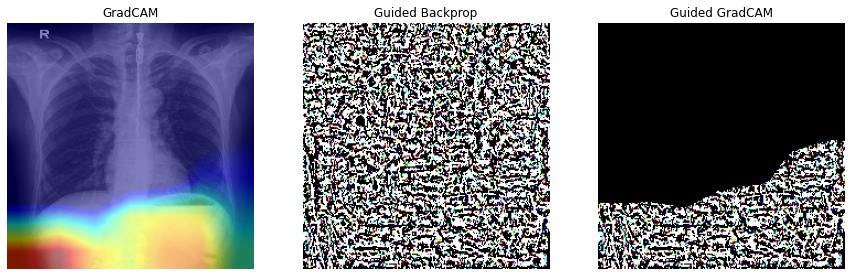

In [ ]:
out = compute_saliency(model, guided_model, layer_name='conv5_block16_concat',
                                               img_path='/content/00011.jpg', visualize=True, save=False)
gradcam, gb, guided_gradcam = out

predictions shape: (1, 1)
Model prediction:
    ('without objects', array([0.00032784], dtype=float32))    (0)    with probability ('with objects', array([0.9996722], dtype=float32))


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


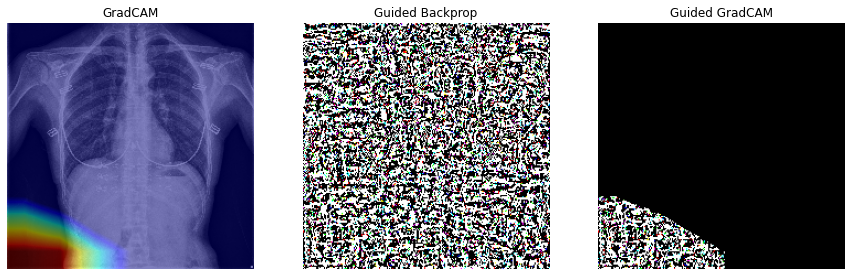

In [ ]:
out = compute_saliency(model, guided_model, layer_name='conv5_block16_concat',
                                               img_path='/content/00012.jpg', visualize=True, save=False)
gradcam, gb, guided_gradcam = out

predictions shape: (1, 1)
Model prediction:
    ('without objects', array([0.29130715], dtype=float32))    (0)    with probability ('with objects', array([0.70869285], dtype=float32))


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


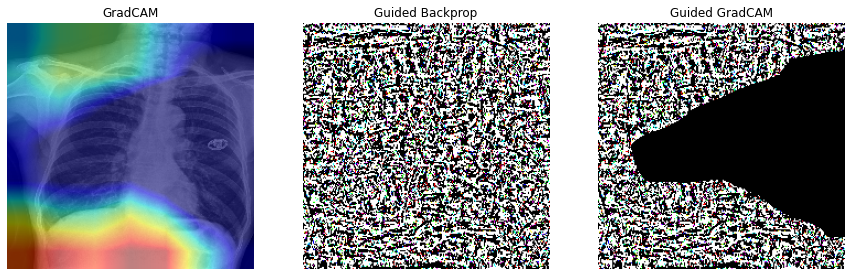

In [ ]:
out = compute_saliency(model, guided_model, layer_name='conv5_block16_concat',
                                               img_path='/content/00013.jpg', visualize=True, save=False)
gradcam, gb, guided_gradcam = out

predictions shape: (1, 1)
Model prediction:
    ('without objects', array([0.93885314], dtype=float32))    (0)    with probability ('with objects', array([0.06114686], dtype=float32))


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


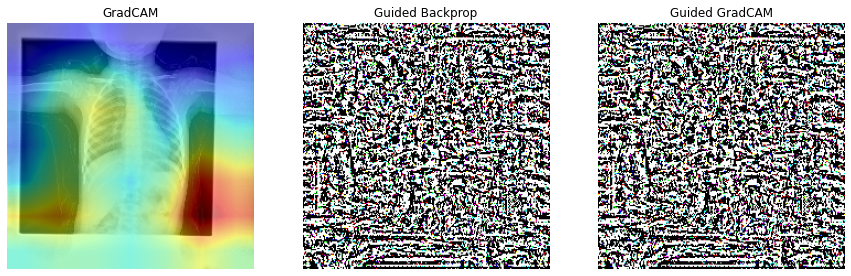

In [ ]:
out = compute_saliency(model, guided_model, layer_name='conv5_block16_concat',
                                               img_path='/content/00014.jpg', visualize=True, save=False)
gradcam, gb, guided_gradcam = out

In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3_backbone (InputLayer)   (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
zero_padding2d_5_backbone (Zero (None, 230, 230, 3)  0           input_3_backbone[0][0]           
__________________________________________________________________________________________________
conv1/conv_backbone (Conv2D)    (None, 112, 112, 64) 9408        zero_padding2d_5_backbone[0][0]  
__________________________________________________________________________________________________
conv1/bn_backbone (BatchNormali (None, 112, 112, 64) 256         conv1/conv_backbone[0][0]        
____________________________________________________________________________________________

In [ ]:
!pip install tf_explain
import tf_explain
from tf_explain.callbacks.grad_cam import GradCAM

# Load a sample image (or multiple ones)
img = keras.preprocessing.image.load_img('/content/00004.jpg', target_size=(224, 224, 3))
img = keras.preprocessing.image.img_to_array(img)
img = img/255.
data = ([img], None)

# Start explainer
explainer = GradCAM()
grid = explainer.explain(data, model, class_index=1)

explainer.save(grid, ".", "grad_cam.png")

AttributeError: ignored

In [ ]:
backbone_model = load_model_and_weights('simple_backbone_model')
head_model = load_model_and_weights('simple_head_model - exp 3')
# model_input = backbone_model.input
# backbone_intermediate_output = backbone_model.get_layer(head_model.layers[0].name).output
# model_output = head_model(backbone_intermediate_output)
# model = keras.models.Model(inputs=model_input, outputs=model_output)

In [ ]:
head_model.predict()

['_uses_inputs_arg',
 'inputs',
 'outputs',
 'name',
 'trainable',
 'dtype',
 '_is_compiled',
 '_expects_training_arg',
 '_initial_weights',
 'supports_masking',
 'optimizer',
 '_trainable_weights',
 '_non_trainable_weights',
 '_updates',
 '_losses',
 '_per_input_losses',
 '_per_input_updates',
 '_metrics',
 '_layers',
 '_outbound_nodes',
 '_inbound_nodes',
 '_compute_previous_mask',
 '_built',
 '_is_graph_network',
 '_input_layers',
 '_output_layers',
 '_input_coordinates',
 '_output_coordinates',
 '_output_mask_cache',
 '_output_tensor_cache',
 '_output_shape_cache',
 '_network_nodes',
 '_nodes_by_depth',
 '_layers_by_depth',
 'input_names',
 'output_names',
 '_feed_input_names',
 '_feed_inputs',
 '_feed_input_shapes',
 '__module__',
 '__doc__',
 'compile',
 'metrics',
 'metrics_names',
 'reset_metrics',
 '_check_trainable_weights_consistency',
 '_make_train_function',
 '_make_test_function',
 '_make_predict_function',
 '_uses_dynamic_learning_phase',
 '_set_inputs',
 '_standardize_u